# Import data and libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import re
import string
from wordcloud import WordCloud

from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec

from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam

import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)
import joblib
from tqdm import tqdm

import contractions
import shap

In [2]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
data = pd.read_csv("../data/twitter_parsed_dataset.csv")
data

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...,...
16846,5.75606766236475E+017,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0
16847,5.72333822886326E+017,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


In [4]:
data = data.drop(columns=['id', 'index', "Annotation"])
data.columns = ['text', 'label']
data

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0
...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0


In [5]:
data['text'].sample(1).values[0]

'@GerardGeorges4 @AlsisiOfficial Word is that the YPG/YPJ has for the first time encroached on Raqqa province today. They took a hill there.'

In [6]:
data['text'][0]

'@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj'

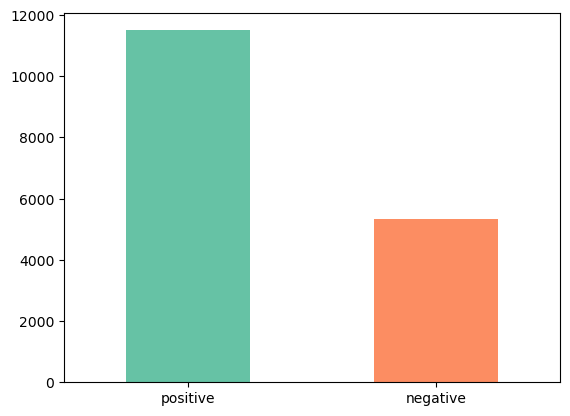

In [7]:
data['label'].value_counts().plot(kind='bar', color=sns.color_palette('Set2'))
plt.xticks([0,1],['positive', 'negative'], rotation=0);

# EDA

In [8]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    return sample

In [9]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(str(x)))
data

,text,label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...
4,#mkr No No No No No No,0.0,mkr no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


In [10]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
def get_wordnet_pos(word):
    treebank_tag = nltk.pos_tag([word])[0][1]
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    sample = text
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    if spell:
        sample = str(TextBlob(text).correct())
    return sample

In [11]:
data['correct_text'] = 'text'
data

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,text
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,text
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,text
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,text
4,#mkr No No No No No No,0.0,mkr no no no no no no,text
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,text
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,text
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,text
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,text


In [12]:
count = 0
for text in tqdm(data['cleaned_text']):
    data['correct_text'][count] = correct_text(text, lemma=True)
    count +=1

  0%|          | 0/16851 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 16851/16851 [01:51<00:00, 151.80it/s]


In [13]:
data

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,rt call sexist go auto place would rather talk...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,wrong isi follow example mohammed quran exactly
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block


In [14]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data['correct_text'].str.len() ## this also includes spaces
data

,text,label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,7,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,12,82
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,rt call sexist go auto place would rather talk...,10,50
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,wrong isi follow example mohammed quran exactly,7,47
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,1,3
...,...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,9,42
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,10,50
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,14,93
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,3,17


<Axes: >

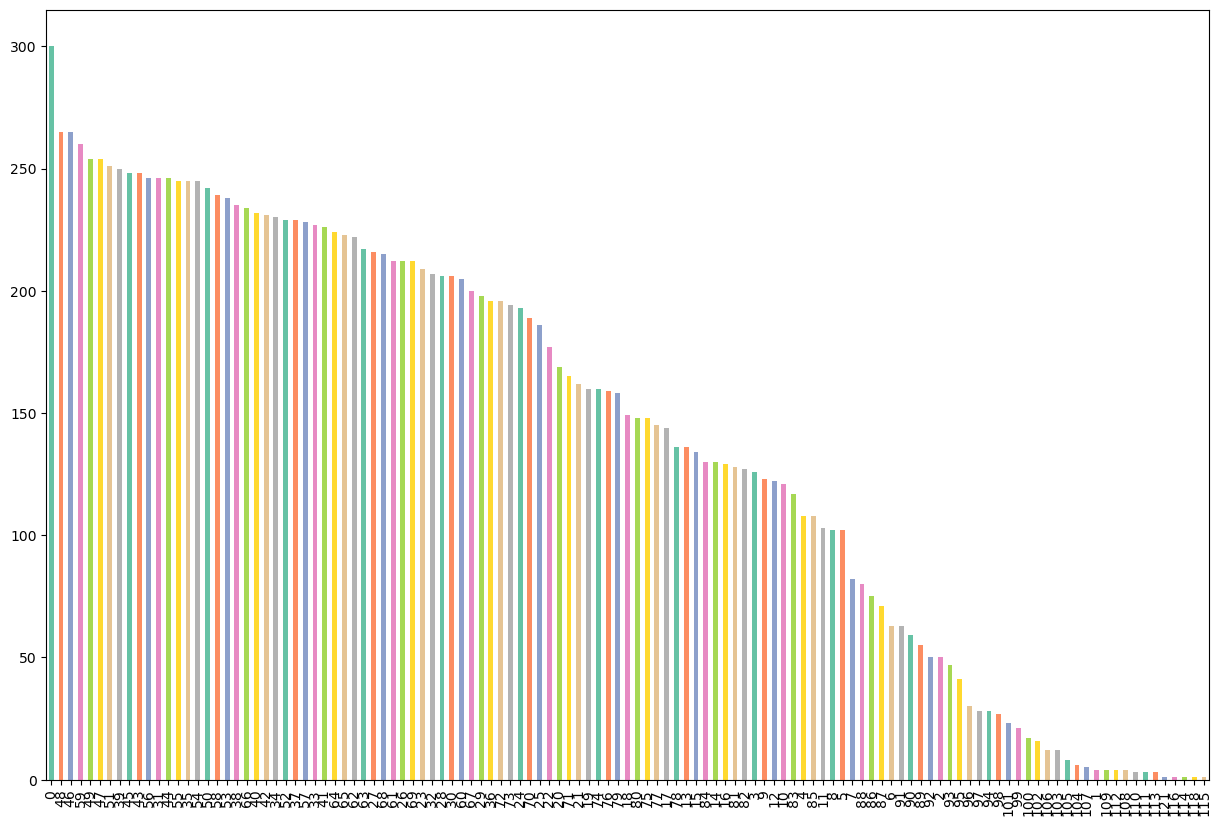

In [15]:
plt.figure(figsize=(15,10))
data['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('Set2'))

In [16]:
data.loc[data['char_count'] == 0]

,text,label,cleaned_text,correct_text,word_count,char_count
149,@JillWetzler I ❤️ u,0.0,i you,,1,0
154,"@gamer456ism @femfreq @StephenAtHome ""you're""",0.0,you are,,1,0
179,@dankmtl @PeaceNotHate_ http://t.co/HxgNJvWoqG,0.0,,,1,0
211,@Assiye61 http://t.co/dduX3ZbMtE,0.0,,,1,0
240,@98Halima @BilalIGhumman @johnnygjokaj @cdnKha...,0.0,,,1,0
...,...,...,...,...,...,...
16576,@olaoliv http://t.co/6PmFc7kdYh,0.0,,,1,0
16719,@iAmCaticorn @CherguiaMbark http://t.co/igBq14...,0.0,,,1,0
16771,@ROJNAME_english http://t.co/Ej5MsCentH,0.0,,,1,0
16778,@98Halima @BilalIGhumman @johnnygjokaj @cdnKha...,0.0,,,1,0


In [17]:
data = data[~(data['char_count'] == 0)].reset_index(drop=True)

In [18]:
data[(data['label'] == 0)]

,text,label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,7,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,12,82
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,1,3
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,rt saudi preacher who raped and tortured his f...,rt saudi preacher rap torture five year old da...,11,66
7,Going to make some pancakes.....Don't hve any ...,0.0,going to make some pancakes do not hve any str...,go make pancake hve strawberry hve banana mkr,8,45
...,...,...,...,...,...,...
16546,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,9,42
16547,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,10,50
16548,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,14,93
16549,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,3,17


In [19]:
g = str(data[data['label'] == 0]['correct_text'])
g

'0        read context change meaning history islamic sl...\n1        idiot claim people try stop become terrorist m...\n4                                                      mkr\n5        rt saudi preacher rap torture five year old da...\n7            go make pancake hve strawberry hve banana mkr\n                               ...                        \n16546           feel sorry girl safe kat andre go home mkr\n16547    mkr pretty good dish happy ok well never eat p...\n16548    rt deconstruct lemon tart please go one season...\n16549                                    stupid talk block\n16550    protest mad much reason would tweet woman femi...\nName: correct_text, Length: 11210, dtype: object'

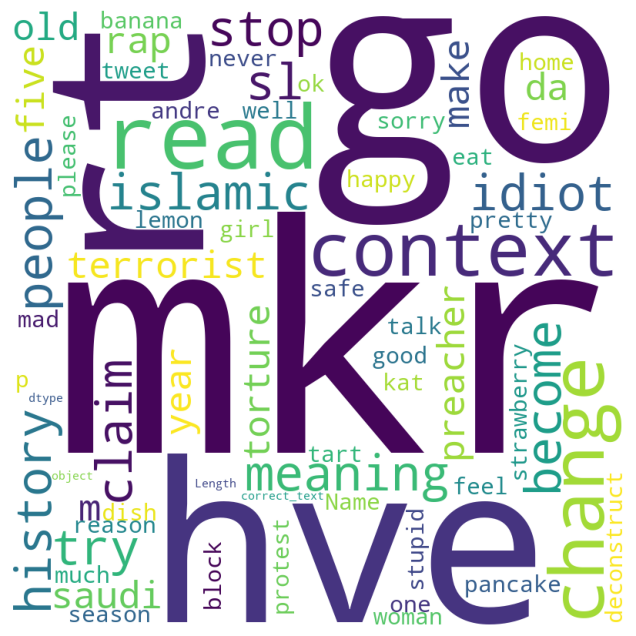

In [20]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
plt.show()

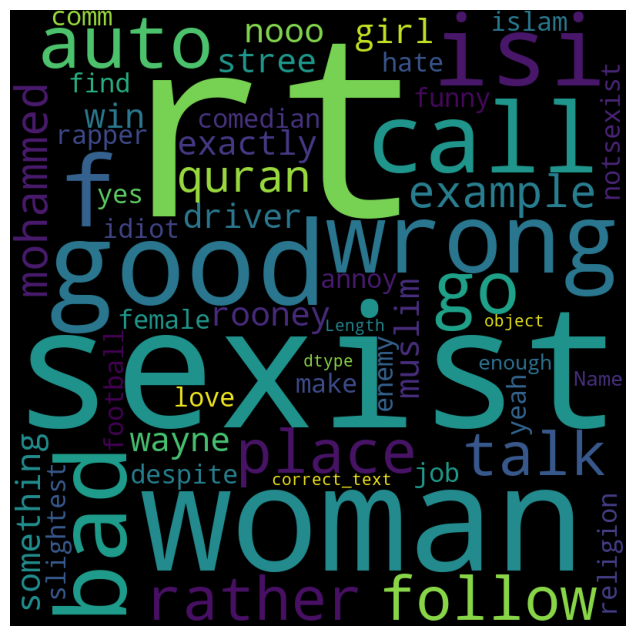

In [21]:
g = str(data[data['label']==1]['correct_text'])
wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
# plot the WordCloud image                        
# plt.tight_layout(pad = 0) 
plt.show()

In [46]:
final_data = data.drop(columns=['text', 'cleaned_text', 'word_count', 'char_count'])
# final_data.to_csv("final_cleaned_data.csv", index=False)

In [23]:
# final_data = pd.read_csv('final_cleaned_data.csv')
final_data

,label,correct_text
0,0.0,read context change meaning history islamic sl...
1,0.0,idiot claim people try stop become terrorist m...
2,1.0,rt call sexist go auto place would rather talk...
3,1.0,wrong isi follow example mohammed quran exactly
4,0.0,mkr
...,...,...
16546,0.0,feel sorry girl safe kat andre go home mkr
16547,0.0,mkr pretty good dish happy ok well never eat p...
16548,0.0,rt deconstruct lemon tart please go one season...
16549,0.0,stupid talk block


# Build Vocabulary

In [24]:
# load doc and add to vocab
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)

def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()

In [25]:
vocab = Counter()
for text in final_data['correct_text']:
    build_vocab(vocab, text)

In [26]:
print(vocab.most_common(50))

[('mkr', 4941), ('rt', 3683), ('woman', 1236), ('kat', 1104), ('sexist', 1095), ('get', 1064), ('like', 1043), ('go', 991), ('islam', 926), ('muslim', 793), ('would', 747), ('people', 742), ('make', 707), ('amp', 691), ('one', 670), ('say', 626), ('think', 618), ('girl', 595), ('cannot', 555), ('know', 554), ('andre', 548), ('want', 526), ('see', 517), ('time', 482), ('isi', 481), ('look', 466), ('well', 453), ('call', 446), ('fuck', 428), ('really', 400), ('good', 398), ('men', 383), ('need', 379), ('thing', 372), ('right', 360), ('even', 322), ('oh', 305), ('way', 303), ('give', 303), ('u', 303), ('take', 303), ('talk', 300), ('female', 294), ('never', 291), ('bad', 290), ('use', 287), ('try', 285), ('year', 285), ('hate', 281), ('show', 278)]


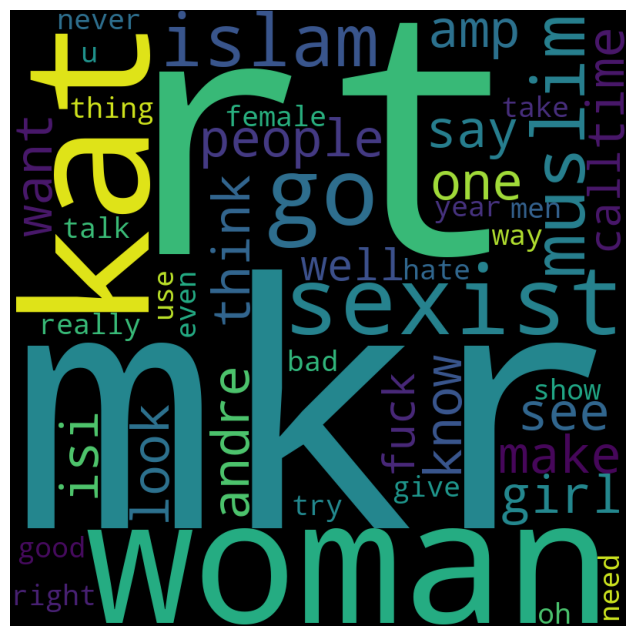

In [27]:
g = " ".join([x[0] for x in vocab.most_common(50)])
wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
plt.show()

In [28]:
save__vocab_list(vocab, 'vocab.txt')

# Modeling

In [29]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

#  define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [30]:
X = final_data['correct_text']
y = final_data['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [32]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [33]:
vocab_set = set([x for x in vocab if len(x)>2])
tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [34]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [35]:
clf_model = define_model(vocab_size, max_length, x_train.shape[1])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1047500   
                                                                 
 flatten (Flatten)           (None, 2300)              0         
                                                                 
 dense (Dense)               (None, 45)                103545    
                                                                 
 dense_1 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1,151,091
Trainable params: 1,151,091
Non-trainable params: 0
_________________________________________________________________


In [36]:
clf_model.fit(x_train, y_train.values, epochs=10, verbose=2, batch_size=74)

Train on 11089 samples
Epoch 1/10
11089/11089 - 2s - loss: 0.6231 - acc: 0.6826 - 2s/epoch - 151us/sample
Epoch 2/10
11089/11089 - 2s - loss: 0.5845 - acc: 0.6913 - 2s/epoch - 137us/sample
Epoch 3/10
11089/11089 - 2s - loss: 0.5207 - acc: 0.7646 - 2s/epoch - 136us/sample
Epoch 4/10
11089/11089 - 1s - loss: 0.4368 - acc: 0.8197 - 1s/epoch - 131us/sample
Epoch 5/10
11089/11089 - 1s - loss: 0.3677 - acc: 0.8511 - 1s/epoch - 116us/sample
Epoch 6/10
11089/11089 - 1s - loss: 0.3158 - acc: 0.8737 - 1s/epoch - 124us/sample
Epoch 7/10
11089/11089 - 1s - loss: 0.2745 - acc: 0.8940 - 1s/epoch - 127us/sample
Epoch 8/10
11089/11089 - 1s - loss: 0.2397 - acc: 0.9135 - 1s/epoch - 109us/sample
Epoch 9/10
11089/11089 - 1s - loss: 0.2097 - acc: 0.9264 - 1s/epoch - 117us/sample
Epoch 10/10
11089/11089 - 2s - loss: 0.1828 - acc: 0.9400 - 2s/epoch - 149us/sample


In [37]:
clf_model.evaluate(x_train, y_train, verbose=0)[1]

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


0.9508522

In [38]:
clf_model.evaluate(x_test, y_test, verbose=0)[1]

0.81728303

In [39]:
clf_model.predict(x_test[0].reshape(1,-1))[0,0]

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


0.7363542

In [40]:
def predict_sentiment(text, vocab=vocab_set, tokenizer=tokenizer, max_length=max_length, model=clf_model):
    line = text
    # clean review
    line = clean_text(line)
    line = correct_text(line)
    line = " ".join([word for word in line.split() if word in vocab])
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    # print(yhat)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [41]:
predict_sentiment(final_data['correct_text'][3], vocab_set, tokenizer, max_length, clf_model)

(0.9031641, 'POSITIVE')

In [42]:
final_data['correct_text'][3]

'wrong isi follow example mohammed quran exactly'

In [43]:
predict_sentiment(final_data['correct_text'][1], vocab_set, tokenizer, max_length, clf_model)

(0.5596100687980652, 'NEGATIVE')

In [44]:
final_data['correct_text'][1]

'idiot claim people try stop become terrorist make terrorist islamically brain dead'

In [45]:
clf_model.save('clf_seq.h5')